# Nos capítulos anteriores...

No primeiro arquivo (https://github.com/renanmath/imersao-dados-desafio-final/blob/main/Alura_DesafioDados_analise_experimentos.ipynb) fizemos a análsie exploratória do banco de dados com as informações dos experimentos realizados com os compostos, na busca por novos fármacos. 
Esse experimentos produziram resultados, os quais foram coletados em um segundo banco de dados. Nesse arquivo, faremos a análise desse novo data set. 

Antes, precisamos executar novamente alguns códigos.

In [2]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') #ignora as mensagens de aviso

In [3]:
url_dados = 'https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_experimentos.zip?raw=true'
df = pd.read_csv(url_dados, compression = 'zip')
df.head()


,id,tratamento,tempo,dose,droga,g-0,g-1,g-2,g-3,g-4,g-5,g-6,g-7,g-8,g-9,g-10,g-11,g-12,g-13,g-14,g-15,g-16,g-17,g-18,g-19,g-20,g-21,g-22,g-23,g-24,g-25,g-26,g-27,g-28,g-29,g-30,g-31,g-32,g-33,g-34,...,c-60,c-61,c-62,c-63,c-64,c-65,c-66,c-67,c-68,c-69,c-70,c-71,c-72,c-73,c-74,c-75,c-76,c-77,c-78,c-79,c-80,c-81,c-82,c-83,c-84,c-85,c-86,c-87,c-88,c-89,c-90,c-91,c-92,c-93,c-94,c-95,c-96,c-97,c-98,c-99
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.4805,0.4965,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.4083,0.0319,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.5477,-0.7576,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.1220,-0.3752,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,-0.2274,0.3215,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125


In [4]:
#Renomeando as colunas, eliminando '-'
colunas = df.columns.to_numpy()  #cria um array com os nomes das colunas
for i in range(0,colunas.shape[0]):
   colunas[i] = colunas[i].replace('-','')  #faz um loop percorrendo os índices do array, trocando '-' por ''
df.columns = colunas  #renomeia as colunas
df.rename(columns= {'droga':'composto'}, inplace = True) #renomeia a coluna 'droga' para 'composto'
df.tail() #mostra os 5 últimos regristos

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,0.0807,0.4024,-0.0895,0.4420,0.9641,-0.1846,-0.0014,0.3154,-0.2071,-0.6158,-0.2977,0.0992,0.6838,0.5259,0.7882,0.3119,-0.7697,0.2203,-1.0710,0.5979,0.0848,-0.2555,0.6293,1.1660,0.3329,0.2754,0.4108,-0.1252,-0.2340,0.2267,0.1969,0.0262,-0.8121,0.3434,0.5372,-0.3246,0.0631,0.9171,0.5258,0.4680
23810,id_fffb70c0c,com_droga,24,D2,ecf3b6b74,-1.3260,0.3478,-0.3743,0.9905,-0.7178,0.6621,-0.2252,-0.5565,0.5112,0.6727,-0.1851,2.8650,-0.2140,-0.6153,0.8362,0.5584,-0.2589,0.1292,0.0148,0.0949,-0.2182,-0.9235,0.0749,-1.5910,-0.8359,-0.9217,0.3013,0.1716,0.0880,0.1842,0.1835,0.5436,-0.0533,-0.0491,0.9543,...,0.1410,1.2640,-0.8663,0.8129,-0.1514,-0.4652,-0.7390,-1.3270,0.9925,1.0570,-0.3355,-0.2555,0.8219,0.6995,-0.2942,0.2408,-0.7781,-0.0929,-0.0329,0.0781,-1.4440,-0.0921,0.3188,-1.1080,0.4895,-0.2144,1.0960,0.3335,0.4444,-1.1130,0.4286,0.4426,0.0423,-0.3195,-0.8086,-0.9798,-0.2084,-0.1224,-0.2715,0.3689
23811,id_fffc1c3f4,com_controle,48,D2,cacb2b860,0.3942,0.3756,0.3109,-0.7389,0.5505,-0.0159,-0.2541,0.1745,-0.0340,0.4865,-0.1854,0.0716,0.1729,-0.0434,0.1542,-0.2192,-0.0302,-0.4218,0.4057,-0.5372,0.1521,-0.2651,0.2310,-0.8101,0.4943,0.6905,-0.3720,-1.4110,0.4516,1.2300,-0.1949,-1.3280,-0.4276,-0.0040,-0.3086,...,0.6845,0.7127,0.7294,0.4718,-0.2020,0.2783,0.4934,0.4144,0.5449,1.4690,-0.6142,0.6068,0.3434,0.9880,-0.0468,-0.1882,-0.0087,-0.0356,0.5718,0.4971,0.1057,0.2111,0.6992,0.0708,0.6169,0.2248,0.5994,0.2689,0.0305,1.2320,0.5409,0.3755,0.7343,0.2807,0.4116,0.6422,0.2256,0.7592,0.6656,0.3808
23812,id_fffcb9e7c,com_droga,24,D1,8b87a7a83,0.6660,0.2324,0.4392,0.2044,0.8531,-0.0343,0.0323,0.0463,0.4299,-0.7985,0.5742,0.1421,2.2700,0.2046,0.5363,-1.7330,0.1450,0.6097,0.2024,0.9865,-0.7805,0.9608,0.3440,2.7650,0.4925,0.6698,0.2374,-0.3372,0.8771,-2.6560,-0.2000,-0.2043,0.6797,-0.0248,-0.0927,...,0.3360,-0.6136,0.5011,0.9261,0.4419,0.0295,0.4220,0.4677,-0.1184,0.4524,0.4135,0.1356,-0.5801,0.0411,1.0240,1.0340,-0.0270,-0.4194,0.7403,-0.6793,-0.1423,0.7307,0.7946,-0.0650,0.9038,0.2324,0.9676,1.0940,0.4290,0.5187,-0.1105,0.4258,-0.2012,0.1506,1.5230,0.7101,0.1732,0.7015,-0.6290,0.0740
23813,id_ffffdd77b,com_droga,72,D1,972f41291,-0.8598,1.0240,-0.1361,0.7952,-0.3611,-3.6750,-1.2420,0.9146,3.0790,1.2460,1.9460,1.4370,2.9780,2.2370,-0.6818,0.6870,-1.1060,0.0182,-0.9247,-0.0738,-0.1919,-0.7722,-1.4050,-1.0050,-1.1170,-0.5293,-1.1720,-0.2885,0.1599,-0.4250,0.3591,-0.1420,-0.9530,-0.2005,-1.8340,...,-6.9170,-1.8640,-2.5090,-4.7130,-1.7250,-3.8650,-3.0800,-4.1530,-1.2030,-1.1690,-4.1460,-1.2670,-1.1300,-2.4390,0.1591,-2.2490,-2.5860,-1.9520,-2.1810,-4.6690,-3.9450,-2.9560,-2.7930,-2.1560,-2.4100,-1.8190,-3.3480,-0.1414,-2.6430,-2.5810,-3.3890,-1.7450,-6.6300,-4.0950,-7.3860,-1.4160,-3.5770,-0.4775,-2.1500,-4.2520


# Novos dados: resultados dos experimentos

## Preparação e análise inicial

Vamos agora inserir uma nova base de dados, que contém os resultados dos estudos realizados. Começamos importando os dados:

In [5]:
df_resultados = pd.read_csv('https://github.com/alura-cursos/imersaodados3/blob/main/dados/dados_resultados.csv?raw=true')
df_resultados

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Nessa nova base de dados, vemos a ação de cada composto comparado com cada mecanismo de ação da droga: 1 para quando o mecanismo é ativado, 0 para quando não é ativado.
Foram considerados 206 mecanismos de ação (que vamos abreviar por MOA ou moa). Cada um desses MOA tem uma finalidade (inibidores, ativadores, agosnistas, antagonistas, etc). O objetivo do estudo é descobrir quais desses MOA são ativados por cada composto do experimento, para assim avaliarmos se tal composto é útil ou não para o próposito estabelecido. 
Façamos uma contagem para saber quantas vezes cada mecanismo de ação (moa) foi ativado:

In [6]:
contagem = df_resultados.drop('id', axis=1).sum().sort_values(ascending=False)
contagem

nfkb_inhibitor                                832
proteasome_inhibitor                          726
cyclooxygenase_inhibitor                      435
dopamine_receptor_antagonist                  424
serotonin_receptor_antagonist                 404
                                             ... 
protein_phosphatase_inhibitor                   6
autotaxin_inhibitor                             6
diuretic                                        6
erbb2_inhibitor                                 1
atp-sensitive_potassium_channel_antagonist      1
Length: 206, dtype: int64

Assim, observamos que os MOAs nfkb_inhibitor, proteasome_inhibitor e cyclooxygenase_inhibitor foram os três mais ativados. Os três são mecanismos do tipo inibidor. 

Vamos encontrar as top 10 moa que mais aparecem no estudo.

In [7]:
from collections import Counter
suf = []
contador = []
suf_moa = pd.DataFrame()
for nome in df_resultados.columns[1:]:
  suf.append(nome.split('_')[-1])

pd.DataFrame(Counter(suf), index = [0]).iloc[:,0:10]
top10_moa = pd.DataFrame()
top10_moa['Ação'] = pd.DataFrame(Counter(suf), index = [0]).iloc[:,0:10].columns
top10_moa['Total de ocorrências'] = pd.DataFrame(Counter(suf), index = [0]).iloc[:,0:10].T.values
top10_moa

,Ação,Total de ocorrências
0,inhibitor,112
1,agonist,28
2,antagonist,32
3,activator,5
4,analgesic,1
5,local,1
6,anti-inflammatory,1
7,antiarrhythmic,1
8,antibiotic,1
9,anticonvulsant,1


Constatamos que de fato os MOAs inibidores teveram maior ocorrência, seguido de agonista e antagonista. 

Podemos refinar o questionamento: quantas vezes cada MOA foi ativado por algum composto?

In [8]:
lista_acoes = []
lista_ativacoes = []
for nome in df_resultados.columns[1:]:
  acao = nome.split('_')[-1] 
  total_ativacoes = df_resultados[nome].sum()
  lista_acoes.append(acao)
  lista_ativacoes.append(total_ativacoes)

tab_acoes_parcial = pd.DataFrame()
tab_acoes_parcial['Acão do composto'] = lista_acoes
tab_acoes_parcial['Total de ativações'] = lista_ativacoes
tab_acoes_parcial

,Acão do composto,Total de ativações
0,inhibitor,17
1,inhibitor,18
2,inhibitor,24
3,agonist,190
4,antagonist,301
...,...,...
201,inhibitor,6
202,inhibitor,170
203,b,26
204,agonist,39


In [9]:
top10_acoes = tab_acoes_parcial.groupby(by = 'Acão do composto').sum().sort_values(by = 'Total de ativações', ascending = False)[0:10]
top10_acoes.reset_index(level=0, inplace=True)
top10_acoes

,Acão do composto,Total de ativações
0,inhibitor,9693
1,antagonist,3449
2,agonist,2330
3,blocker,323
4,agent,150
5,activator,115
6,local,80
7,antioxidant,73
8,anti-inflammatory,73
9,immunosuppressant,73


Assim, observamos que de fato o moa inibidor não apenas é o mais frequente como o que foi mais ativado nos estudos, seguido de agonista e antagonista. 
Curioso que a ação bloqueador (blocker) aparece apenas uma vez, mas foi ativada 323 vezes, figurando em quarto lugar no ranking de MOAs mais ativados. O mesmo comentário se aplica aos moa 'agent', 'local', 'antioxidant', 'anti-inflammatory' e 'immunosuppressant'. 

Vejamos essas informações em um gráfico de barras

<BarContainer object of 10 artists>

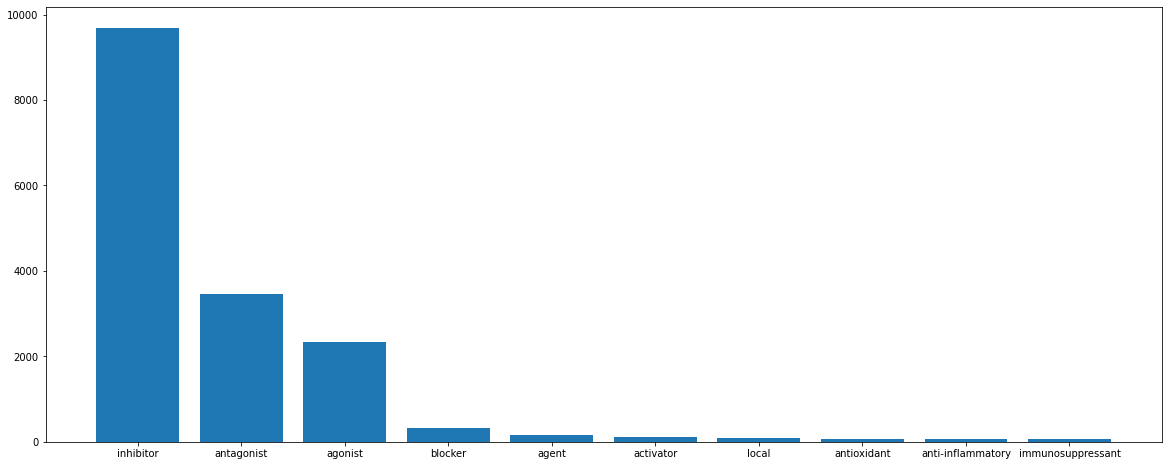

In [10]:
from matplotlib.pyplot import figure
figure(figsize = (20,8))
plt.bar(data = top10_acoes, x = 'Acão do composto', height = top10_acoes['Total de ativações'])

## Merge com os dados iniciais

Vamos agora criar uma nova coluna que conterá a informação: quantos MOAs foram ativados por cada composto.

In [11]:
df_resultados['n_moa'] = df_resultados.drop('id', axis=1).sum(axis=1)

Podemos também nos perguntar se o composto ativou ou não um moa. 

In [12]:
df_resultados['ativo_moa'] = (df_resultados['n_moa'] != 0)*1
df_resultados.head()

,id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,aurora_kinase_inhibitor,...,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,n_moa,ativo_moa
0,id_000644bb2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
1,id_000779bfc,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1
3,id_0015fd391,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1


Queremos agora dar um passo adiante e comparar os dados das nossas duas tabelas. Para isso, precisamos criar uma tabela total, com informações de ambas, usando o comando merge(). Isso só funciona porque as duas tabelas contém uma coluna em comum, o 'id'. 

In [13]:
df_total = pd.merge(df, df_resultados[['id','n_moa', 'ativo_moa']], on='id')
df_total.head()

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99,n_moa,ativo_moa
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.3680,0.8427,0.1042,0.1403,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,1
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,0.3905,0.7099,0.2912,0.4151,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.0444,0.1894,-0.0014,-2.3640,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,1
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-2.3820,-3.7350,-2.9740,-1.4930,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1535,-0.4640,-0.5943,0.3973,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,1


Vejamos a ação do grupo de controle:

In [14]:
df_total.query('tratamento == "com_controle"' )['ativo_moa'].value_counts()

0    1866
Name: ativo_moa, dtype: int64

Com esse comando vemos que nenhum moa foi ativado pelo composto do grupo de controle, o que é exatamente o que se espera do grupo de controle.

Vejamos se outros compostos também não ativaram MOAs.

In [15]:
df_total.query('tratamento == "com_droga"' )['ativo_moa'].value_counts()

1    14447
0     7501
Name: ativo_moa, dtype: int64

Vemos aqui que alguns compostos (7501 para sermos mais precisos) não ativaram nenhum moa.

Vamos agora criar a coluna 'Eh_controle' que vai retornar 1 se tratamento = 'com_controle' e 0 caso contrário. 
E também colunas que nos digam se o tempo do tratamento foi ou não de 24, 48 e 72 horas.

In [16]:
df_total['Eh controle'] = (df_total['tratamento'] == 'com_controle')*1
df_total['Tempo eh 24'] = (df_total['tempo'] == 24)*1
df_total['Tempo eh 48'] = (df_total['tempo'] == 48)*1
df_total['Tempo eh 72'] = (df_total['tempo'] == 72)*1

In [17]:
df_total

,id,tratamento,tempo,dose,composto,g0,g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12,g13,g14,g15,g16,g17,g18,g19,g20,g21,g22,g23,g24,g25,g26,g27,g28,g29,g30,g31,g32,g33,g34,...,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99,n_moa,ativo_moa,Eh controle,Tempo eh 24,Tempo eh 48,Tempo eh 72
0,id_000644bb2,com_droga,24,D1,b68db1d53,1.0620,0.5577,-0.2479,-0.6208,-0.1944,-1.0120,-1.0220,-0.0326,0.5548,-0.0921,1.1830,0.1530,0.5574,-0.4015,0.1789,-0.6528,-0.7969,0.6342,0.1778,-0.3694,-0.5688,-1.1360,-1.1880,0.6940,0.4393,0.2664,0.1907,0.1628,-0.2853,0.5819,0.2934,-0.5584,-0.0916,-0.3010,-0.1537,...,0.1758,1.2570,-0.5979,1.2250,-0.0553,0.7351,0.5810,0.9590,0.2427,0.0495,0.4141,0.8432,0.6162,-0.7318,1.2120,0.6362,-0.4427,0.1288,1.4840,0.1799,0.5367,-0.1111,-1.0120,0.6685,0.2862,0.2584,0.8076,0.5523,-0.1912,0.6584,-0.3981,0.2139,0.3801,0.4176,1,1,0,1,0,0
1,id_000779bfc,com_droga,72,D1,df89a8e5a,0.0743,0.4087,0.2991,0.0604,1.0190,0.5207,0.2341,0.3372,-0.4047,0.8507,-1.1520,-0.4201,-0.0958,0.4590,0.0803,0.2250,0.5293,0.2839,-0.3494,0.2883,0.9449,-0.1646,-0.2657,-0.3372,0.3135,-0.4316,0.4773,0.2075,-0.4216,-0.1161,-0.0499,-0.2627,0.9959,-0.2483,0.2655,...,-0.2840,-0.3104,-0.6373,0.2887,-0.0765,0.2539,0.4443,0.5932,0.2031,0.7639,0.5499,-0.3322,-0.0977,0.4329,-0.2782,0.7827,0.5934,0.3402,0.1499,0.4420,0.9366,0.8193,-0.4236,0.3192,-0.4265,0.7543,0.4708,0.0230,0.2957,0.4899,0.1522,0.1241,0.6077,0.7371,0,0,0,0,0,1
2,id_000a6266a,com_droga,48,D1,18bb41b2c,0.6280,0.5817,1.5540,-0.0764,-0.0323,1.2390,0.1715,0.2155,0.0065,1.2300,-0.4797,-0.5631,-0.0366,-1.8300,0.6057,-0.3278,0.6042,-0.3075,-0.1147,-0.0570,-0.0799,-0.8181,-1.5320,0.2307,0.4901,0.4780,-1.3970,4.6240,-0.0437,1.2870,-1.8530,0.6069,0.4290,0.1783,0.0018,...,-0.4682,0.1210,-0.5177,-0.0604,0.1682,-0.4436,0.4963,0.1363,0.3335,0.9760,-0.0427,-0.1235,0.0959,0.0690,-0.9416,-0.7548,-0.1109,-0.6272,0.3019,0.1172,0.1093,-0.3113,0.3019,-0.0873,-0.7250,-0.6297,0.6103,0.0223,-1.3240,-0.3174,-0.6417,-0.2187,-1.4080,0.6931,3,1,0,0,1,0
3,id_0015fd391,com_droga,48,D1,8c7f86626,-0.5138,-0.2491,-0.2656,0.5288,4.0620,-0.8095,-1.9590,0.1792,-0.1321,-1.0600,-0.8269,-0.3584,-0.8511,-0.5844,-2.5690,0.8183,-0.0532,-0.8554,0.1160,-2.3520,2.1200,-1.1580,-0.7191,-0.8004,-1.4670,-0.0107,-0.8995,0.2406,-0.2479,-1.0890,-0.7575,0.0881,-2.7370,0.8745,0.5787,...,-1.6600,-3.1660,0.2816,-0.2990,-1.1870,-0.5044,-1.7750,-1.6120,-0.9215,-1.0810,-3.0520,-3.4470,-2.7740,-1.8460,-0.5568,-3.3960,-2.9510,-1.1550,-3.2620,-1.5390,-2.4600,-0.9417,-1.5550,0.2431,-2.0990,-0.6441,-5.6300,-1.3780,-0.8632,-1.2880,-1.6210,-0.8784,-0.3876,-0.8154,0,0,0,0,1,0
4,id_001626bd3,com_droga,72,D2,7cbed3131,-0.3254,-0.4009,0.9700,0.6919,1.4180,-0.8244,-0.2800,-0.1498,-0.8789,0.8630,-0.2219,-0.5121,-0.9577,1.1750,0.2042,0.1970,0.1244,-1.7090,-0.3543,-0.5160,-0.3330,-0.2685,0.7649,0.2057,1.3720,0.6835,0.8056,-0.3754,-1.2090,0.2965,-0.0712,0.6389,0.6674,-0.0783,1.1740,...,0.1500,0.5178,0.5159,0.6091,0.1813,-0.4249,0.7832,0.6529,0.5648,0.4817,0.0587,0.5303,0.6376,-0.3966,-1.4950,-0.9625,-0.0541,0.6273,0.4563,0.0698,0.8134,0.1924,0.6054,-0.1824,0.0042,0.0048,0.6670,1.0690,0.5523,-0.3031,0.1094,0.2885,-0.3786,0.7125,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,com_droga,24,D2,df1d0a5a1,0.1394,-0.0636,-0.1112,-0.5080,-0.4713,0.7201,0.5773,0.3055,-0.4726,0.1269,0.2531,0.1730,-0.4532,-1.0790,0.2474,-0.4550,0.3588,0.1600,-0.7362,-0.1103,0.8550,-0.4139,0.5541,0.2310,-0.5573,-0.4397,-0.9260,-0.2424,-0.6686,0.2326,0.6456,0.0136,-0.5141,-0.6320,0.7166,...,-0.0014,0.3154,-0.2071,-0.6158,-0.2977,0.0992,0.6838,0.5259,0.7882,0.3119,-0.7697,0.2203,-1.0710,0.5979,0.0848,-0.2555,0.62

## Boxplots

Vejamos alguns boxplots da ação compostos mais frequentes na variância gênica g0.

In [18]:
composto_principal = df_total['composto'].value_counts()[0:10]
composto_principal

cacb2b860    1866
87d714366     718
9f80f3f77     246
8b87a7a83     203
5628cb3ee     202
d08af5d4b     196
292ab2c28     194
d50f18348     186
d1b47f29d     178
67c879e79      19
Name: composto, dtype: int64

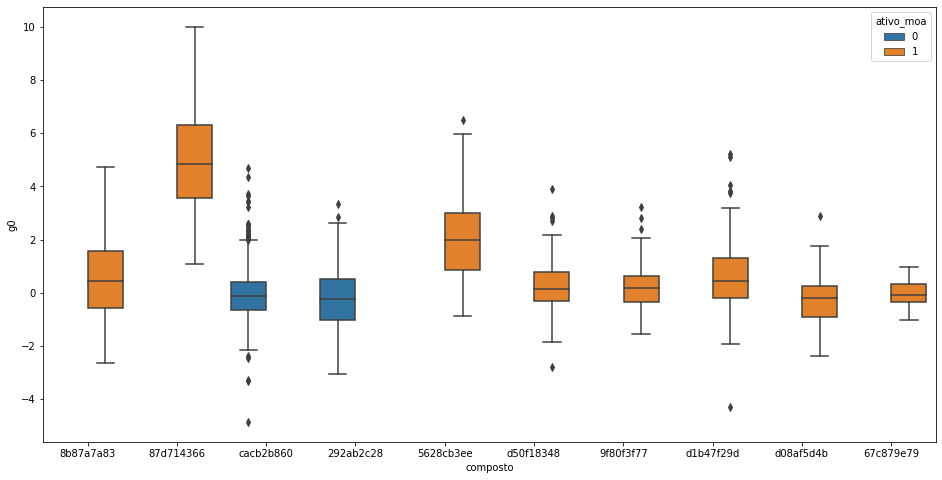

In [19]:
composto_principal = df_total['composto'].value_counts().index[:10]
plt.figure(figsize=(16,8))
sns.boxplot(data = df_total.query('composto in @composto_principal'), y= 'g0', x='composto', hue='ativo_moa')

Vemos que o composto cacb2b860 não ativou nenhum MOA, mas isso já foi observado, já que ele é o composto do grupo de controle. Porém, outro composto dentre os mais frequentes também não ativou nehuum moa, a saber, 292ab2c28. E ambos tem distribuição semelhante. 

Vejamos outros boxplots, por tempo e por dose.

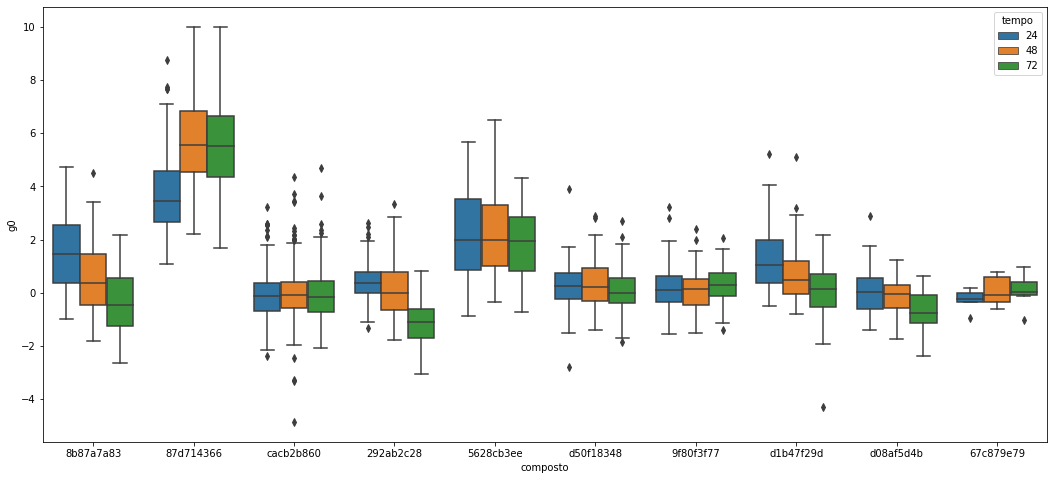

In [20]:
plt.figure(figsize=(18,8))
sns.boxplot(data = df_total.query('composto in @composto_principal'), y= 'g0', x='composto', hue='tempo')

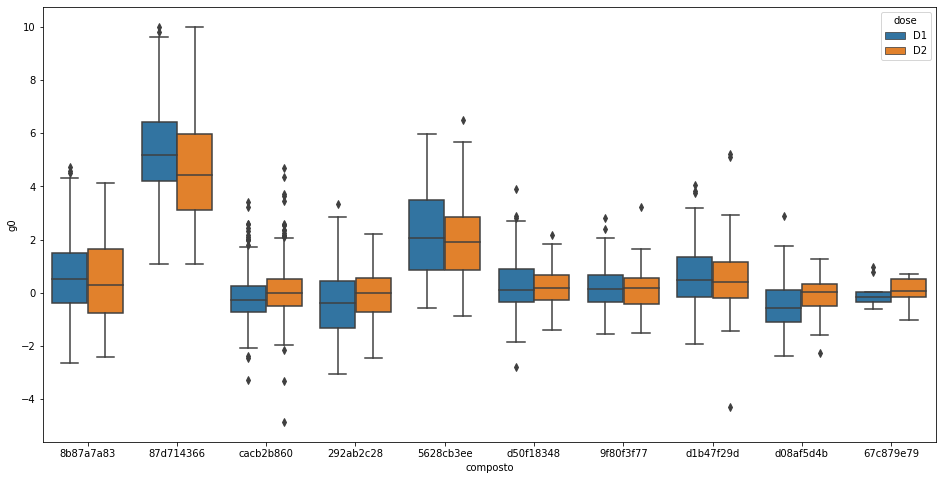

In [21]:
plt.figure(figsize=(16,8))
sns.boxplot(data = df_total.query('composto in @composto_principal'), y= 'g0', x='composto', hue='dose')

## Ativação de MOAs

Nosso objetivo agora é verificar se existem compostos que ativaram diferentes MOAs em diferentes cenários do experimentos (diferentes tempos e doses). 
Para isso, vamos construir uma tabela que terá na primeira colunas os compostos e na segunda colunas os moa que foram ativados por esses compostos durante o experimento. 

Antes disso, porém, vamos criar uma função auxiliar, que transforma uma lista de strings em uma única string, pois iremos precisar de um método que faça esse processo.

In [22]:
def listToString(s): 
    
    
    str1 = "" 
    
     
    for ele in s: 
        str1 += ele  
    
      
    return str1 

Também iremos precisar de um novo data frame, que contenha ao mesmo tempo a coluna 'composto' e as colunas dos MOAs. Então faremos um novo merge:

In [23]:
df_unido = pd.merge(df[['id', 'composto']], df_resultados.drop(['n_moa', 'ativo_moa'], axis=1), on='id')
df_unido

,id,composto,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,adrenergic_receptor_agonist,adrenergic_receptor_antagonist,akt_inhibitor,aldehyde_dehydrogenase_inhibitor,alk_inhibitor,ampk_activator,analgesic,androgen_receptor_agonist,androgen_receptor_antagonist,anesthetic_-_local,angiogenesis_inhibitor,angiotensin_receptor_antagonist,anti-inflammatory,antiarrhythmic,antibiotic,anticonvulsant,antifungal,antihistamine,antimalarial,antioxidant,antiprotozoal,antiviral,apoptosis_stimulant,aromatase_inhibitor,atm_kinase_inhibitor,atp-sensitive_potassium_channel_antagonist,atp_synthase_inhibitor,atpase_inhibitor,atr_kinase_inhibitor,...,protein_synthesis_inhibitor,protein_tyrosine_kinase_inhibitor,radiopaque_medium,raf_inhibitor,ras_gtpase_inhibitor,retinoid_receptor_agonist,retinoid_receptor_antagonist,rho_associated_kinase_inhibitor,ribonucleoside_reductase_inhibitor,rna_polymerase_inhibitor,serotonin_receptor_agonist,serotonin_receptor_antagonist,serotonin_reuptake_inhibitor,sigma_receptor_agonist,sigma_receptor_antagonist,smoothened_receptor_antagonist,sodium_channel_inhibitor,sphingosine_receptor_agonist,src_inhibitor,steroid,syk_inhibitor,tachykinin_antagonist,tgf-beta_receptor_inhibitor,thrombin_inhibitor,thymidylate_synthase_inhibitor,tlr_agonist,tlr_antagonist,tnf_inhibitor,topoisomerase_inhibitor,transient_receptor_potential_channel_antagonist,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,b68db1d53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,df89a8e5a,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,18bb41b2c,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,8c7f86626,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,7cbed3131,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,df1d0a5a1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,ecf3b6b74,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,cacb2b860,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,8b87a7a83,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


Agora sim estamos prontos para criar nossa tabela. O código abaixo infelizmente não é o mais rápido (vai levar em torno de 25 min para executar), mas foi o que eu consegui pensar. 

In [ ]:
tab_moe_ativados = pd.DataFrame()
tab_moe_ativados['composto'] = df_unido['composto']
tab_moe_ativados['moe ativados'] = df_unido['composto']
for i in range(0, df_unido.shape[0]):
  lista_aux = []
  for col in df_unido.columns[2:]:
    if df_unido.iloc[i][col] == 1:
      lista_aux.append(col + ', ')
    if len(lista_aux) >0:
      tab_moe_ativados.at[i,'moe ativados'] = listToString(lista_aux)[:-2]
    else:
      tab_moe_ativados.at[i,'moe ativados'] = 'Ativou nenhum'
      

tab_moe_ativados  

,composto,moe ativados
0,b68db1d53,gsk_inhibitor
1,df89a8e5a,Ativou nenhum
2,18bb41b2c,"bcr-abl_inhibitor, kit_inhibitor, pdgfr_inhibitor"
3,8c7f86626,Ativou nenhum
4,7cbed3131,calcium_channel_blocker
...,...,...
23809,df1d0a5a1,serotonin_receptor_antagonist
23810,ecf3b6b74,ppar_receptor_agonist
23811,cacb2b860,Ativou nenhum
23812,8b87a7a83,cdk_inhibitor


Temos agora nossa tabela, mas note que ainda precisamos agrupar pelo composto e verificar se não existe algum composto que para um experimento ativou um grupo de MOAs e para um outro experimento ativou um outro grupo de MOAs. 
O próximo código conta, para cada composto, quantos grupos de MOA ele ativa e calcula o máximo dessas quantidades.

In [ ]:
lista_unicos = []
for comp in tab_moe_ativados['composto'].unique():
  lista_unicos.append(len(tab_moe_ativados[tab_moe_ativados['composto'] == comp]['moe ativados'].unique()))
max(lista_unicos)

1

Observamos então que o máximo é 1, portanto nenhum dos composots ativa mais de um grupo de MOAs para experimentos distintos. Isso mostra uma consistência não apenas esperada como desejável para os nossos experimentos. 